In [1]:
import rioxarray
import numpy as np
from multiprocessing import Pool
from scipy import ndimage

In [2]:
# file = 'test/data/mds_sao_paulo_city_4000.tiff'
file = 'test/data/mds_sao_paulo_city_1000.tiff'

In [3]:
xds = rioxarray.open_rasterio(file)

In [4]:
xds.rio.width, xds.rio.height

(1000, 1000)

In [5]:
thetas = 32 # deve ser divisível por 4
phis = 8
observer_h = 1.2 ## TODO
delta_theta = 2*np.pi/thetas
resolution = xds.rio.resolution()
tangents = np.tan(np.pi/2 - np.arcsin(np.arange(1 - 1/phis/2, 1/phis/2, -1/phis)))
indices = np.indices(xds.rio.shape)

In [25]:
indices.shape

(2, 1000, 1000)

In [6]:
svf = np.ones(xds.rio.shape, dtype='int16')

In [7]:
np.indices(np.ones((123, 23)).shape)

array([[[  0,   0,   0, ...,   0,   0,   0],
        [  1,   1,   1, ...,   1,   1,   1],
        [  2,   2,   2, ...,   2,   2,   2],
        ...,
        [120, 120, 120, ..., 120, 120, 120],
        [121, 121, 121, ..., 121, 121, 121],
        [122, 122, 122, ..., 122, 122, 122]],

       [[  0,   1,   2, ...,  20,  21,  22],
        [  0,   1,   2, ...,  20,  21,  22],
        [  0,   1,   2, ...,  20,  21,  22],
        ...,
        [  0,   1,   2, ...,  20,  21,  22],
        [  0,   1,   2, ...,  20,  21,  22],
        [  0,   1,   2, ...,  20,  21,  22]]])

In [8]:
mds = np.arange(3*3).reshape(3, 3)

In [9]:
mds

array([[0, 1, 2],
       [3, 4, 5],
       [6, 7, 8]])

In [10]:
ndimage.rotate(mds, 45, reshape=False)

array([[0, 2, 0],
       [0, 4, 8],
       [0, 6, 0]])

In [12]:
# yr, xr = rotate_2d(mds, np.pi/4)

In [13]:
# yr.shape, xr.shape

In [15]:
# mds[yr, xr]

In [17]:
# mds[xr]

In [18]:
# yr.shape, xr.T.shape

In [19]:
# np.ones((21, 20))[np.int32(yr), np.int32(xr)]

In [35]:
def rotate_2d(mds, angle):
    shape = mds.shape
    print(shape)

    y, x = np.indices(shape,  dtype='float32')
    x, y = x - shape[0]//2, y[::-1] - shape[0]//2

    xr = np.int32(np.cos(angle) * x - np.sin(angle) * y[::-1] + shape[1]//2)
    yr = np.int32(np.sin(angle) * x + np.cos(angle) * y[::-1] + shape[0]//2)
    

    xr = np.where(xr < 0, 0, xr)
    xr = np.where(xr > shape[0]-1, shape[0]-1, xr)
    yr = np.where(yr < 0, 0, yr)
    yr = np.where(yr > shape[1]-1, shape[1]-1, yr)

    return mds[np.int32(yr), np.int32(xr)]
    # return np.int32(yr), np.int32(xr)

In [36]:
def calc_svf_angle(r, t):
    # print("Efetuando Projecao")
    projection = np.rot90(mds_r, k=r) * t + resolution[0] * indices[1]
    # print("Projecao Acumulada")
    projection_acc = np.maximum.accumulate(projection, axis=1)
    # print("comparando ...")
    sky_is_visible = np.less_equal(projection_acc, projection)
    # print("rotacionando de volta")
    return np.rot90(sky_is_visible, k=-r)

In [37]:
## TODO
# Calcular a distancia
# Manter o ũltimo delta de indice antes de ser visivel == True
# indos sempre do mais distante para o mais próximo

In [38]:
xds[0].values

array([[770. , 770. , 770. , ..., 792. , 792. , 792. ],
       [770. , 770. , 770. , ..., 792. , 792. , 792. ],
       [770. , 770. , 770. , ..., 792. , 792. , 792. ],
       ...,
       [766.5, 766.5, 766.5, ..., 792.5, 792.5, 792.5],
       [766.5, 766.5, 766.5, ..., 792.5, 792.5, 792.5],
       [766. , 759.5, 759.5, ..., 792. , 792.5, 792.5]], dtype=float32)

In [39]:
## VErsão refatorada
for i in np.linspace(0, np.pi/2, thetas//4, endpoint=False):

    mds_r = rotate_2d(xds[0].values, i)
    print(np.rad2deg(i))

    p_loop = np.array([[r, t] for r in range(4) for t in tangents])

    with Pool(12) as p:
        svf_part = p.starmap(calc_svf_angle, zip(p_loop[:, 0], p_loop[:, 1]))

    svf += rotate_2d(np.sum(np.array(svf_part), axis=0), -i)



(1000, 1000)
0.0
(1000, 1000)
(1000, 1000)
11.25
(1000, 1000)
(1000, 1000)
22.5
(1000, 1000)
(1000, 1000)
33.75
(1000, 1000)
(1000, 1000)
45.0
(1000, 1000)
(1000, 1000)
56.25
(1000, 1000)
(1000, 1000)
67.5
(1000, 1000)
(1000, 1000)
78.75
(1000, 1000)


In [40]:
svf.shape

(1000, 1000)

In [41]:
xds.values = svf.reshape(1, 1000, 1000)
xds.rio.to_raster('tmp/result_raytracing.tif')

## Calc Understanding

In [123]:
import numpy as np
import matplotlib.pyplot as plt

In [279]:
angle = 30
angle = np.pi/2 - np.deg2rad(angle)
np.random.seed(13)

In [280]:
np.tan(angle)

1.7320508075688776

In [281]:
mds = np.random.RandomState(40).randint(0, 12, 12)
mds

array([ 6, 11,  7,  5,  8,  8,  2,  1,  7,  2,  3, 10])

In [282]:
positions = np.indices(mds.shape)
positions

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]])

In [283]:
mds_projection = mds * np.tan(angle) + (1 * positions)
mds_projection

array([[10.39230485, 20.05255888, 14.12435565, 11.66025404, 17.85640646,
        18.85640646,  9.46410162,  8.73205081, 20.12435565, 12.46410162,
        15.19615242, 28.32050808]])

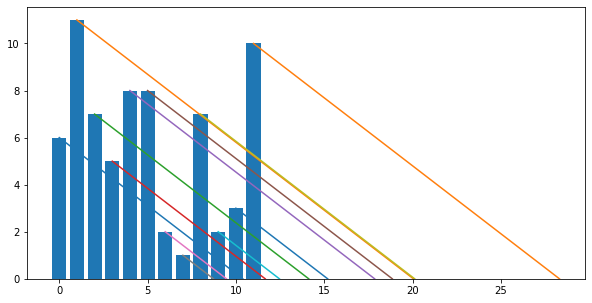

In [284]:
fig = plt.figure(figsize = (10, 5))
plt.bar(positions[0], mds)
# plt.plot(positions[0], mds)
for i in range(mds.shape[0]):
    plt.plot([positions[0][i], mds_projection[0][i]], [mds[i], 0])

In [285]:
max_projection_accumulation = np.maximum.accumulate(mds_projection, axis=1)
max_projection_accumulation

array([[10.39230485, 20.05255888, 20.05255888, 20.05255888, 20.05255888,
        20.05255888, 20.05255888, 20.05255888, 20.12435565, 20.12435565,
        20.12435565, 28.32050808]])

In [286]:
visible = np.less_equal(max_projection_accumulation, mds_projection)
visible

array([[ True,  True, False, False, False, False, False, False,  True,
        False, False,  True]])

In [287]:
max_idx = np.where(max_projection_accumulation==mds_projection)[-1]
idx_repeats = np.pad(max_idx, (0,1), constant_values=12)[1:] - max_idx
max_projection_accumulation_index = np.repeat(max_idx, idx_repeats, axis=0)
max_projection_accumulation_index

array([ 0,  1,  1,  1,  1,  1,  1,  1,  8,  8,  8, 11])

In [288]:
vertical_distance = mds - mds[max_projection_accumulation_index]
vertical_distance

array([  0,   0,  -4,  -6,  -3,  -3,  -9, -10,   0,  -5,  -4,   0])

In [289]:
horizontal_distance = max_projection_accumulation_index - positions
horizontal_distance

array([[ 0,  0, -1, -2, -3, -4, -5, -6,  0, -1, -2,  0]])

In [290]:
vertical_distance, horizontal_distance

(array([  0,   0,  -4,  -6,  -3,  -3,  -9, -10,   0,  -5,  -4,   0]),
 array([[ 0,  0, -1, -2, -3, -4, -5, -6,  0, -1, -2,  0]]))

In [291]:
np.rad2deg(np.arctan2(np.abs(vertical_distance), np.abs(horizontal_distance)))

array([[ 0.        ,  0.        , 75.96375653, 71.56505118, 45.        ,
        36.86989765, 60.9453959 , 59.03624347,  0.        , 78.69006753,
        63.43494882,  0.        ]])

In [265]:
np.rad2deg(np.arctan2(np.abs(vertical_distance), np.abs(horizontal_distance)))

array([[ 0.        ,  0.        , 75.96375653, 71.56505118,  0.        ,
         0.        , 80.53767779, 74.0546041 ,  0.        , 78.69006753,
        63.43494882,  0.        ]])

In [252]:
np.rad2deg(np.arctan2(np.abs(vertical_distance), np.abs(horizontal_distance)))

array([[ 0.        ,  0.        , 75.96375653,  0.        ,  0.        ,
         0.        , 80.53767779,  0.        ,  0.        , 78.69006753,
         0.        ,  0.        ]])